# SSD
- Single Shot detector like YOLO takes only one shot to detect multiple objects present in an image using multibox. It is significantly faster in speed and high-accuracy object detection algorithm. A quick comparison between speed and accuracy of different object detection models on VOC2007
- SSD is a single-shot detector. It has no delegated region proposal network and predicts the boundary boxes and the classes directly from feature maps in one single pass. To improve accuracy, SSD introduces: small convolutional filters to predict object classes and offsets to default boundary boxes.



# How single-shot detector (SSD) works? 
## Image classification and object detection 

- Image classification in computer vision takes an image and predicts the object in an image, while object detection not only predicts the object but also finds their location in terms of bounding boxes. For example, when we build a swimming pool classifier, we take an input image and predict whether it contains a pool, while an object detection model would also tell us the location of the pool. 
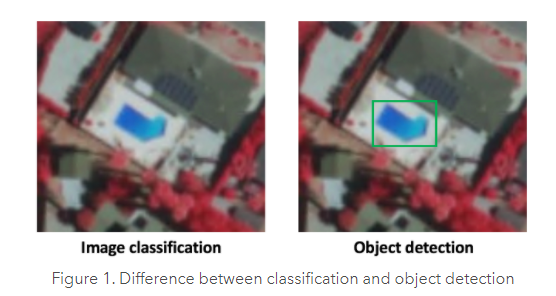
**For illustrative purpose, assuming there is at most one class and one object in an image, the output of an object detection model should include:**

- Probablity that there is an object,
- Height of the bounding box,
- Width of the bounding box,
- Horizontal coordinate of the center point of the bounding box,
- Vertical coordinate of the center point of the bounding box.

> This is just one of the conventions of specifying output. Different models and implementations may have different formats, but the idea is the same, which is to output the probablity and the location of the object.

## Why sliding window approach wouldn't work? 

- It's natural to think of building an object detection model on the top of an image classification model. Once we have a good image classifier, a simple way to detect objects is to slide a 'window' across the image and classify whether the image in that window (cropped out region of the image) is of the desired type. Sounds simple! Well, there are at least two problems:

- (1) How do you know the size of the window so that it always contains the object? Different types of objects (palm tree and swimming pool), even the same type of objects (e.g. a small building and a large buidling) can be of varying sizes as well.
- (2) Aspect ratio (the ratio of height to width of a bounding box). A lot of objects can be present in various shapes like a building footprint will have a different aspect ratio than a palm tree.

To solve these problems, we would have to try out different sizes/shapes of sliding window, which is very computationally intensive, especially with deep neural network.

- In practice, there are two types of mainstream object detection algorithms. Algorithms like R-CNN and Fast(er) R-CNN use a two-step approach - first to identify regions where objects are expected to be found and then detect objects only in those regions using convnet. On the other hand, algorithms like YOLO (You Only Look Once) [1] and SSD (Single-Shot Detector) [2] use a fully convolutional approach in which the network is able to find all objects within an image in one pass (hence ‘single-shot’ or ‘look once’) through the convnet. The region proposal algorithms usually have slightly better accuracy but slower to run, while single-shot algorithms are more efficient and has as good accuracy and that's what we are going to focus on in this section.

## Single-Shot Detector (SSD)
- SSD has two components: a backbone model and SSD head. Backbone model usually is a pre-trained image classification network as a feature extractor. This is typically a network like ResNet trained on ImageNet from which the final fully connected classification layer has been removed. We are thus left with a deep neural network that is able to extract semantic meaning from the input image while preserving the spatial structure of the image albeit at a lower resolution. For ResNet34, the backbone results in a 256 7x7 feature maps for an input image. We will explain what feature and feature map are later on. The SSD head is just one or more convolutional layers added to this backbone and the outputs are interpreted as the bounding boxes and classes of objects in the spatial location of the final layers activations.

In the figure below, the first few layers (white boxes) are the backbone, the last few layers (blue boxes) represent the SSD head.  
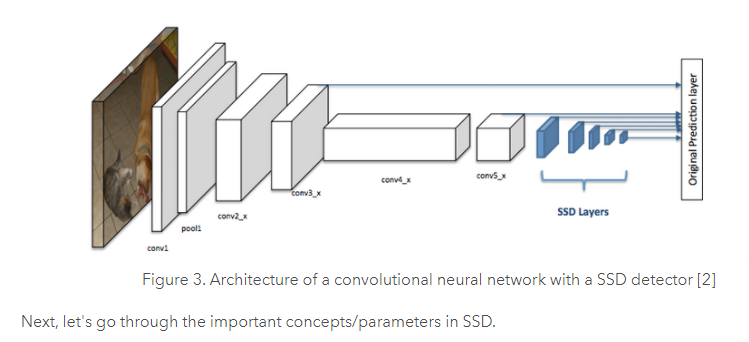

## Grid cell
- Instead of using sliding window, SSD divides the image using a grid and have each grid cell be responsible for detecting objects in that region of the image. Detection objects simply means predicting the class and location of an object within that region. If no object is present, we consider it as the background class and the location is ignored. For instance, we could use a 4x4 grid in the example below. Each grid cell is able to output the position and shape of the object it contains.
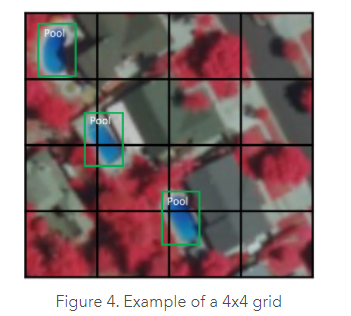
Now you might be wondering what if there are multiple objects in one grid cell or we need to detect multiple objects of different shapes. There is where anchor box and receptive field come into play.

## Anchor box
- Each grid cell in SSD can be assigned with multiple anchor/prior boxes. These anchor boxes are pre-defined and each one is responsible for a size and shape within a grid cell. For example, the swimming pool in the image below corresponds to the taller anchor box while the building corresponds to the wider box. 
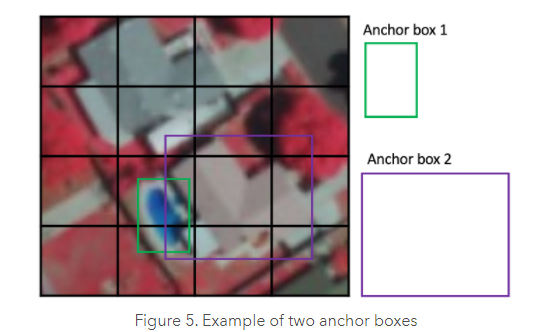
- SSD uses a matching phase while training, to match the appropriate anchor box with the bounding boxes of each ground truth object within an image. Essentially, the anchor box with the highest degree of overlap with an object is responsible for predicting that object’s class and its location. This property is used for training the network and for predicting the detected objects and their locations once the network has been trained. In practice, each anchor box is specified by an aspect ratio and a zoom level.

## Aspect ratio
- Not all objects are square in shape. Some are longer and some are wider, by varying degrees. The SSD architecture allows pre-defined aspect ratios of the anchor boxes to account for this. The ratios parameter can be used to specify the different aspect ratios of the anchor boxes associates with each grid cell at each zoom/scale level.
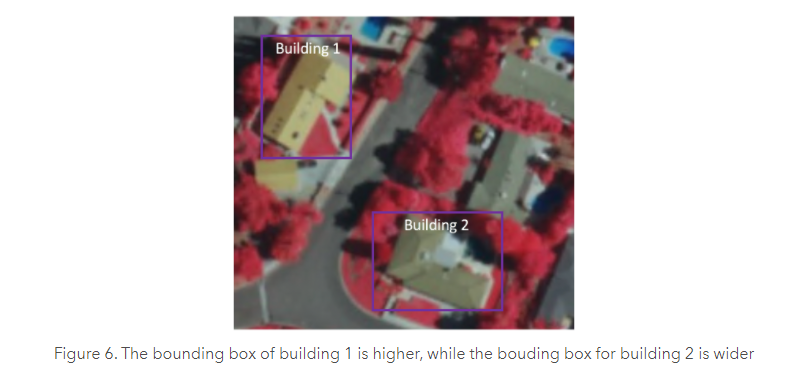
## Zoom level
- It is not necessary for the anchor boxes to have the same size as the grid cell. We might be interested in finding smaller or larger objects within a grid cell. The zooms parameter is used to specify how much the anchor boxes need to be scaled up or down with respect to each grid cell. Just like what we have seen in the anchor box example, the size of building is generally larger than swimming pool.

## Receptive Field 
- Receptive field is defined as the region in the input space that a particular CNN’s feature is looking at (i.e. be affected by). We will use "feature" and "activation" interchangeably here and treat them as the linear combination (sometimes applying an activation function after that to increase non-linearity) of the previous layer at the corresponding location [3]. Because of the the convolution operation, features at different layers represent different sizes of region in the input image. As it goes deeper, the size represented by a feature gets larger. In this example below, we start with the bottom layer (5x5) and then apply a convolution that results in the middle layer (3x3) where one feature (green pixel) represents a 3x3 region of the input layer (bottom layer). And then apply the convolution to middle layer and get the top layer (2x2) where each feature corresponds to a 7x7 region on the input image. These kind of green and orange 2D array are also called feature maps which refer to a set of features created by applying the same feature extractor at different locations of the input map in a sliding window fastion. Features in the same feature map have the same receptive field and look for the same pattern but at different locations. This creates the spatial invariance of ConvNet.

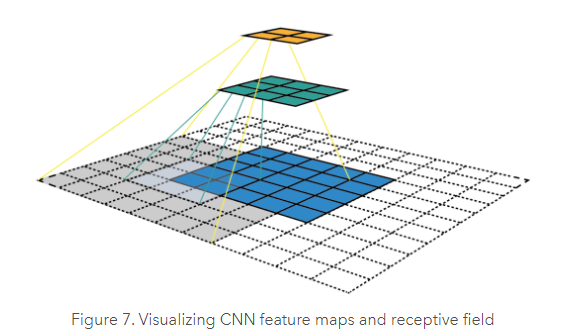
- Receptive field is the central premise of the SSD architecture as it enables us to detect objects at different scales and output a tighter bounding box. Why? As you might still remember, the ResNet34 backbone outputs a 256 7x7 feature maps for an input image. If we specify a 4x4 grid, the simplest approach is just to apply a convolution to this feature map and convert it to 4x4. This approach can actually work to some extent and is exatcly the idea of YOLO (You Only Look Once). The extra step taken by SSD is that it applies more convolutional layers to the backbone feature map and has each of these convolution layers output a object detection results. As earlier layers bearing smaller receptive field can represent smaller sized objects, predictions from earlier layers help in dealing with smaller sized objects.

- Because of this, SSD allows us to define a hierarchy of grid cells at different layers. For example, we could use a 4x4 grid to find smaller objects, a 2x2 grid to find mid sized objects and a 1x1 grid to find objects that cover the entire image.

## SSD implementation in arcgis.learn

- Armed with these fundamental concepts, we are now ready to define a SSD model. arcgis.learn allows us to define a SSD architecture just through a single line of code. For example:

**ssd = SingleShotDetector(data, grids=[4], zooms=[1.0], ratios=[[1.0, 1.0]])**

- The grids parameter specifies the size of the grid cell, in this case 4x4. Additionally, we are specifying a zoom level of 1.0 and aspect ratio of 1.0:1.0. What this essentially means is that the network will create an anchor box for each grid cell, which is the same size as the grid cell (zoom level of 1.0) and is square in shape with an aspect ratio of 1.0:1.0. The output activations along the depth of the final feature map are used to shift and scale (within a reasonable limit) this anchor box so it can approach the actual bounding box of the object even if it doesn’t exactly match with the anchor box.

For more information about the API, please go to the API reference. As arcgis.learn is built upon fast.ai, more explanation about SSD can be found at fast.ai's Multi-object detection lesson [5].